In [1]:
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset

from miniai.datasets import *
from miniai.learner import *

In [2]:
from accelerate import Accelerator

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
class AccelerateCB(TrainCB):
    def __init__(self, mixed_precision):
        self.accelerator = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self):
        model, opt, train, valid = self.accelerator.prepare(self.learn.model, self.learn.opt, self.learn.dls.train, self.learn.dls.valid)
        self.learn.model, self.learn.opt = model, opt
        self.learn.dls.train, self.learn.dls.valid = train, valid

    def backward(self):
        self.accelerator.backward(self.learn.loss)

In [5]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

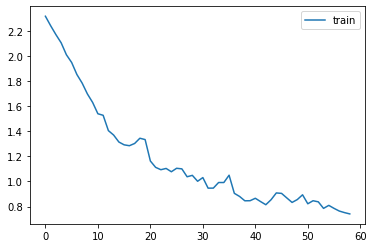

In [6]:
cbs = [AccelerateCB("fp16"), MetricsCB(Accuracy()), ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)